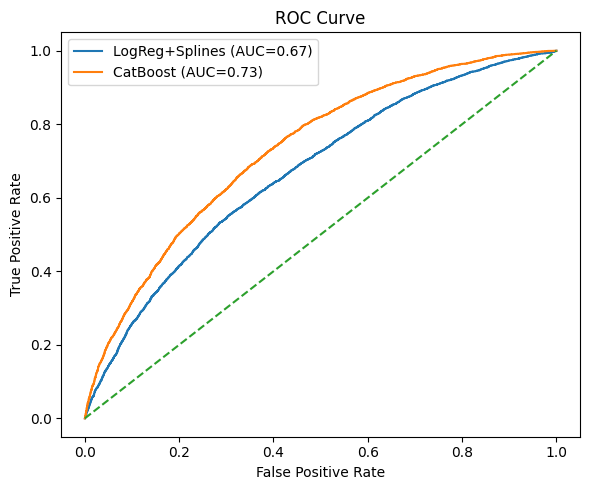

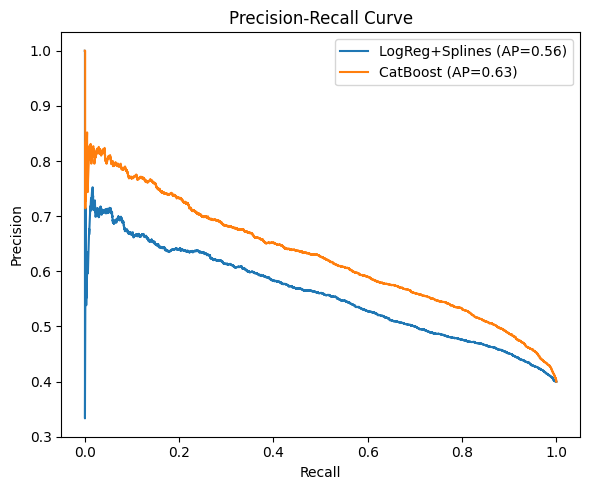

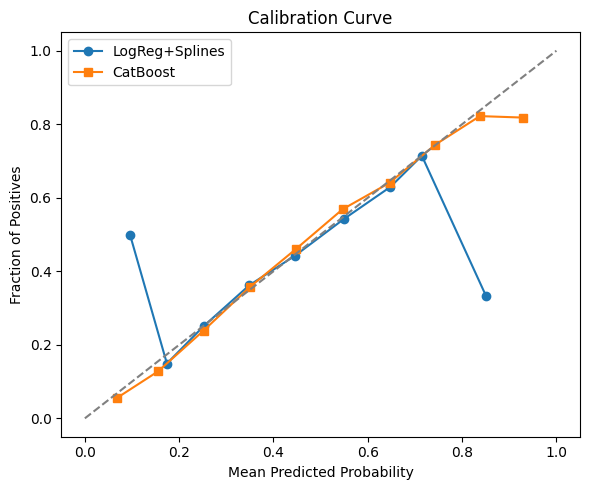

In [72]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, SplineTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    roc_curve, roc_auc_score,
    precision_recall_curve, average_precision_score
)
from sklearn.calibration import calibration_curve
from sklearn.inspection import partial_dependence
from catboost import CatBoostClassifier

# Load and prepare data
X = pd.read_csv('X.csv', index_col=0)
X.diff_stripes = X.diff_stripes*1000
X.ask_median_diff = X.ask_median_diff*1000
y_raw = pd.read_csv('y.csv', index_col=0).squeeze()
y = (y_raw > 0).astype(int)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Fit spline+logreg model
spline_pipeline = Pipeline([
    ("spline", SplineTransformer(degree=3, n_knots=5, include_bias=False, knots="quantile")),
    ("scaler", StandardScaler()),
    ("logreg", LogisticRegression(max_iter=10000, solver="lbfgs"))
])
spline_pipeline.fit(X_train, y_train)

# Fit CatBoost
cb = CatBoostClassifier(iterations=1000, learning_rate=0.1, random_state=42, verbose=False)
cb.fit(X_train, y_train)

# Predict probabilities
proba_log = spline_pipeline.predict_proba(X_test)[:, 1]
proba_cb = cb.predict_proba(X_test)[:, 1]

# ROC Curve
fpr_log, tpr_log, _ = roc_curve(y_test, proba_log)
fpr_cb, tpr_cb, _ = roc_curve(y_test, proba_cb)

plt.figure(figsize=(6, 5))
plt.plot(fpr_log, tpr_log, label=f'LogReg+Splines (AUC={roc_auc_score(y_test, proba_log):.2f})')
plt.plot(fpr_cb, tpr_cb, label=f'CatBoost (AUC={roc_auc_score(y_test, proba_cb):.2f})')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.tight_layout()
plt.show()

# Precision-Recall Curve
prec_log, rec_log, _ = precision_recall_curve(y_test, proba_log)
prec_cb, rec_cb, _ = precision_recall_curve(y_test, proba_cb)

plt.figure(figsize=(6, 5))
plt.plot(rec_log, prec_log, label=f'LogReg+Splines (AP={average_precision_score(y_test, proba_log):.2f})')
plt.plot(rec_cb, prec_cb, label=f'CatBoost (AP={average_precision_score(y_test, proba_cb):.2f})')
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.tight_layout()
plt.show()

# Calibration Curve
prob_true_log, prob_pred_log = calibration_curve(y_test, proba_log, n_bins=10)
prob_true_cb, prob_pred_cb = calibration_curve(y_test, proba_cb, n_bins=10)

plt.figure(figsize=(6, 5))
plt.plot(prob_pred_log, prob_true_log, marker='o', label='LogReg+Splines')
plt.plot(prob_pred_cb, prob_true_cb, marker='s', label='CatBoost')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("Mean Predicted Probability")
plt.ylabel("Fraction of Positives")
plt.title("Calibration Curve")
plt.legend()
plt.tight_layout()
plt.show()



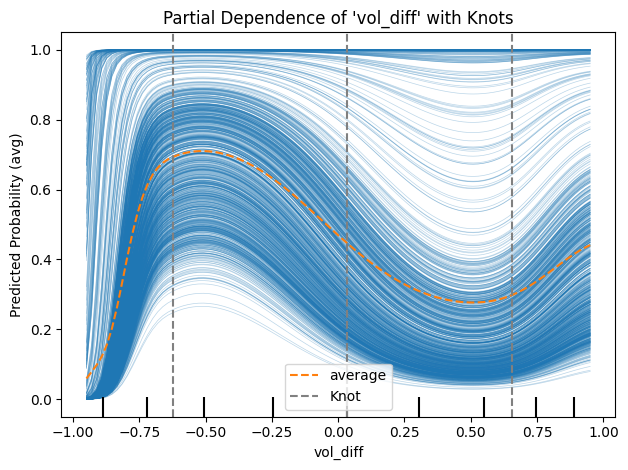

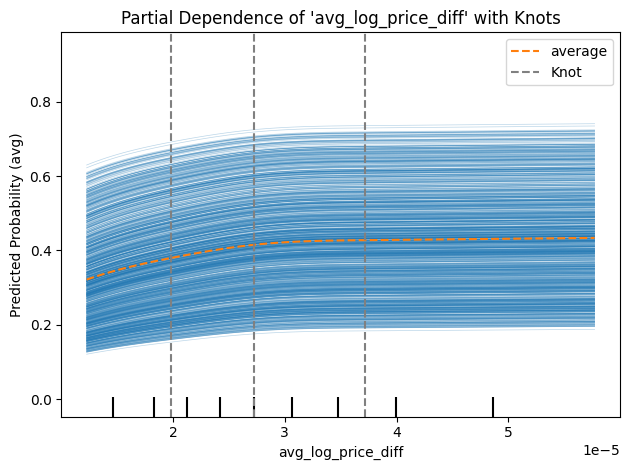

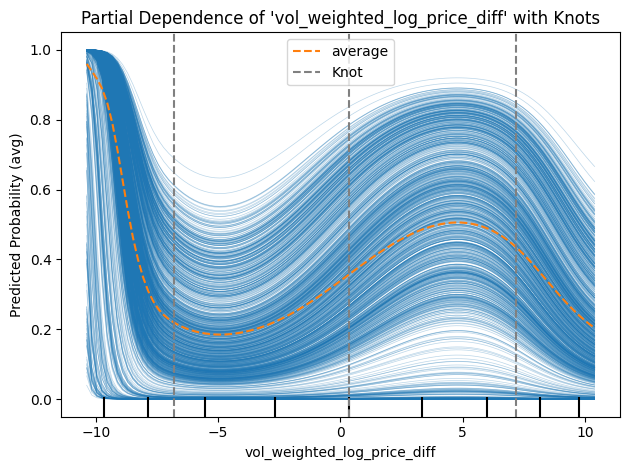

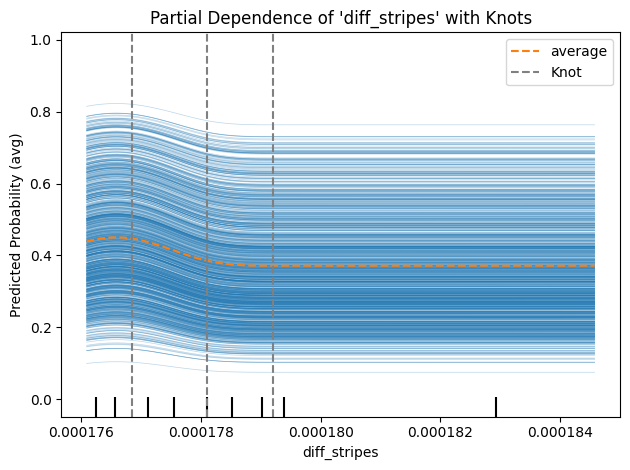

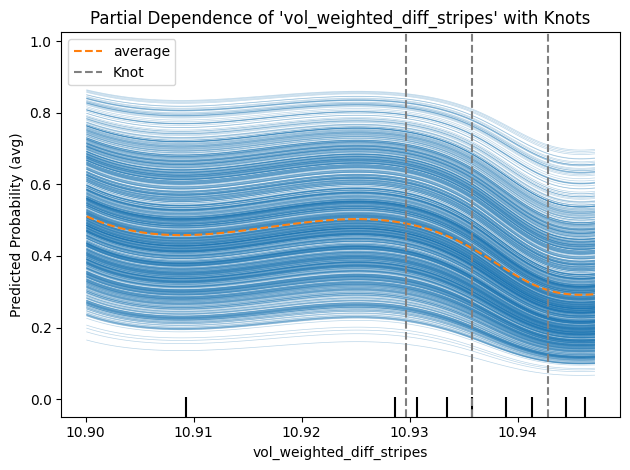

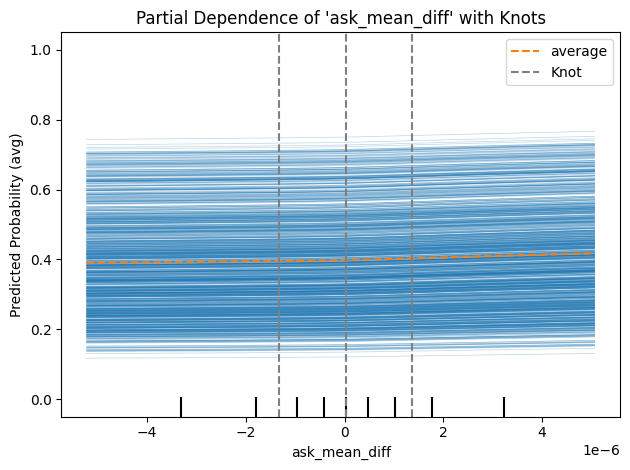

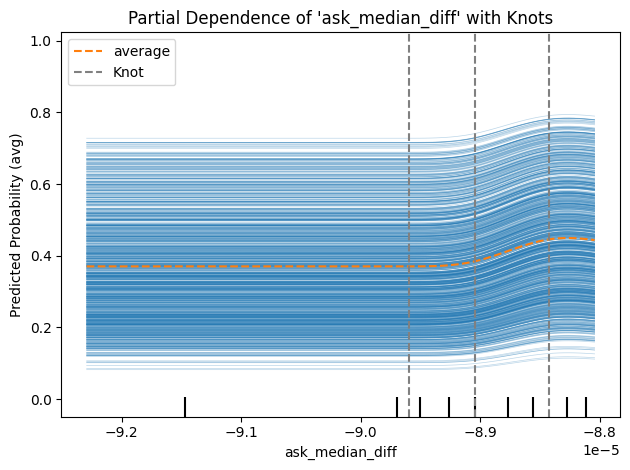

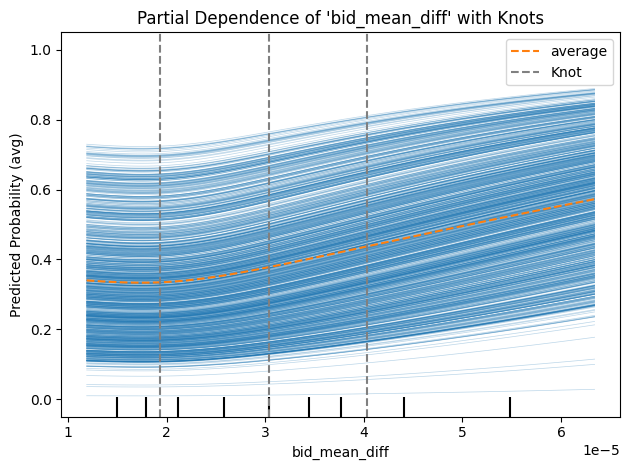

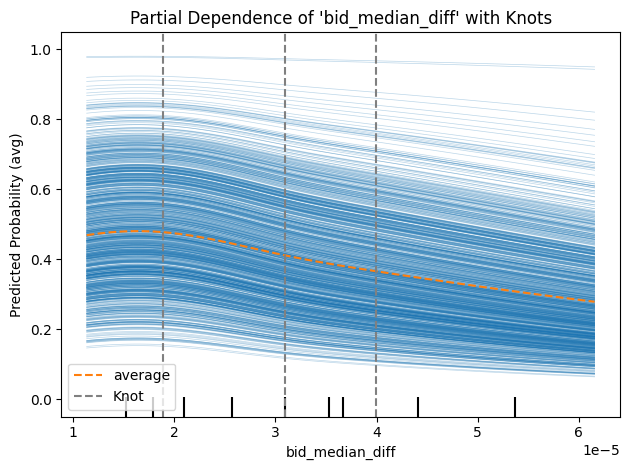

In [60]:
for feature_index in range(len(X.columns)):

    # 6) Choose a feature to plot PDP for
    feature_name  = X_train.columns[feature_index]

    # 7) Compute and plot the partial dependence
    disp = PartialDependenceDisplay.from_estimator(
        spline_pipeline,
        X_train,
        [feature_index],
        kind="both"
    )
    ax = disp.axes_[0, 0]

    # 8) Extract the spline knot locations from the fitted transformer
    #    In scikit-learn v1.5.0, each fitted SplineTransformer stores BSpline objects:
    raw_knots = spline_pipeline.named_steps["spline"] \
                            .bsplines_[feature_index].t
    knots = raw_knots[4:-4]

    # 9) Overlay vertical lines at each knot
    for k in knots:
        ax.axvline(k, color="gray", linestyle="--", label="Knot")

    # 10) Clean up duplicate legend entries
    handles, labels = ax.get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    ax.legend(by_label.values(), by_label.keys())

    ax.set_title(f"Partial Dependence of '{feature_name}' with Knots")
    ax.set_xlabel(feature_name)
    ax.set_ylabel("Predicted Probability (avg)")

    plt.tight_layout()
    plt.show()


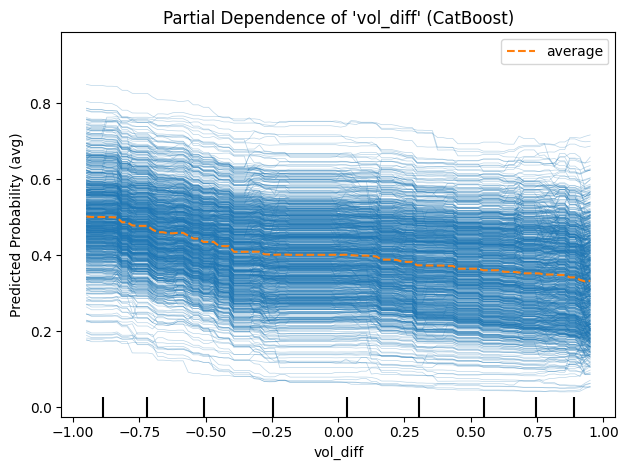

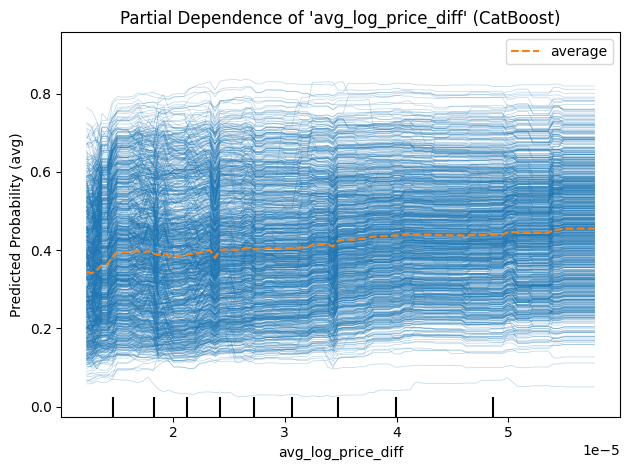

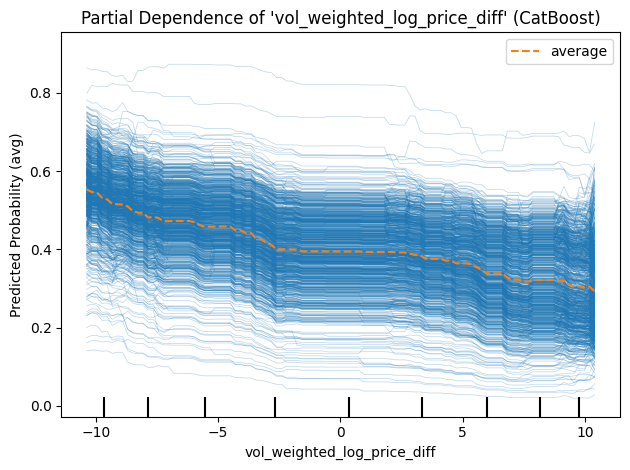

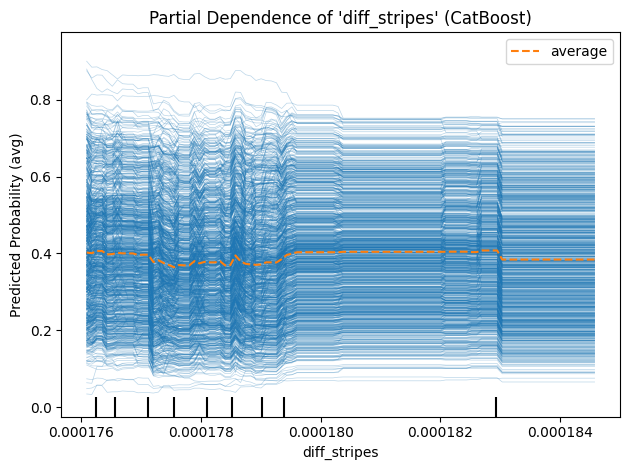

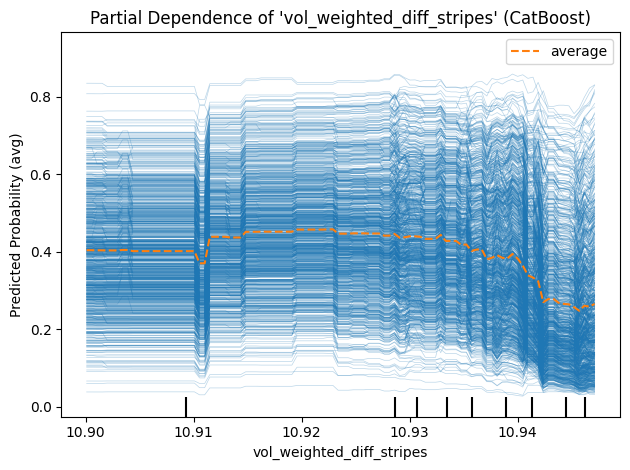

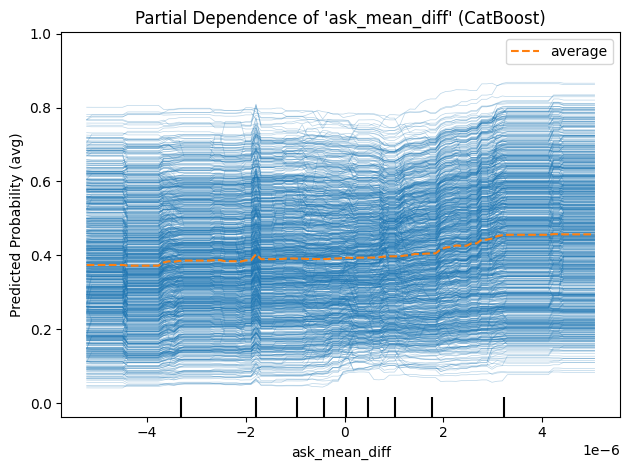

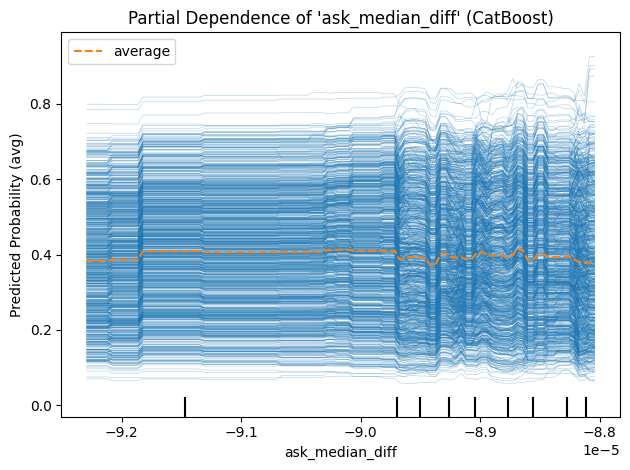

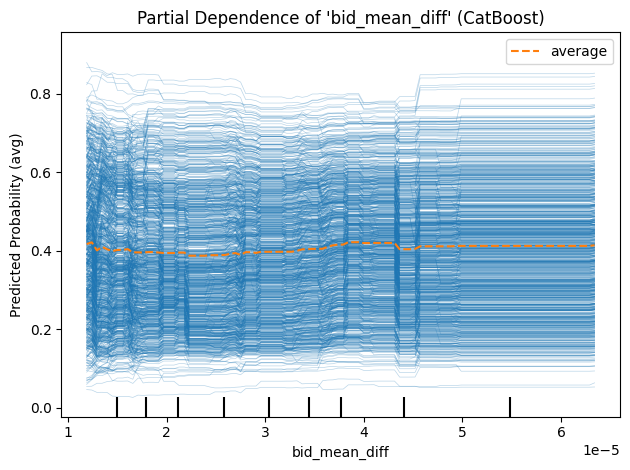

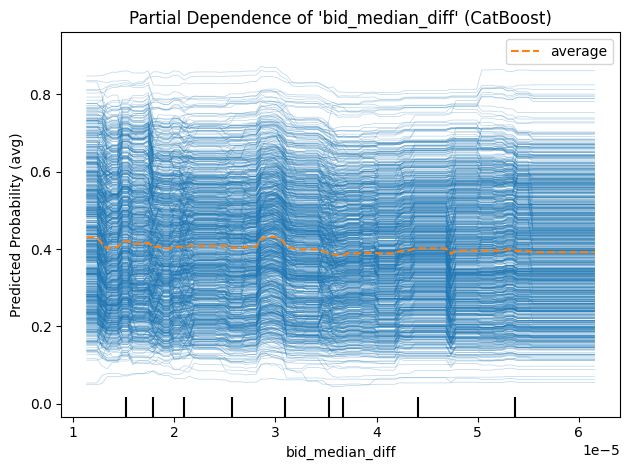

In [62]:
from sklearn.inspection import PartialDependenceDisplay

for feature_index in range(len(X.columns)):

    # 1) Get feature name
    feature_name = X_train.columns[feature_index]

    # 2) Compute and plot the partial dependence for CatBoost
    disp = PartialDependenceDisplay.from_estimator(
        cb,  # ← switched model here
        X_train,
        [feature_index],
        kind="both"
    )
    ax = disp.axes_[0, 0]

    # 3) Set plot labels and title
    ax.set_title(f"Partial Dependence of '{feature_name}' (CatBoost)")
    ax.set_xlabel(feature_name)
    ax.set_ylabel("Predicted Probability (avg)")

    # 4) Show final plot
    plt.tight_layout()
    plt.show()


In [55]:
X.diff_stripes = X.diff_stripes*1000

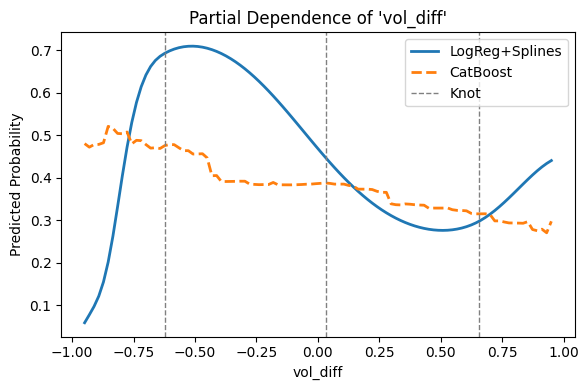

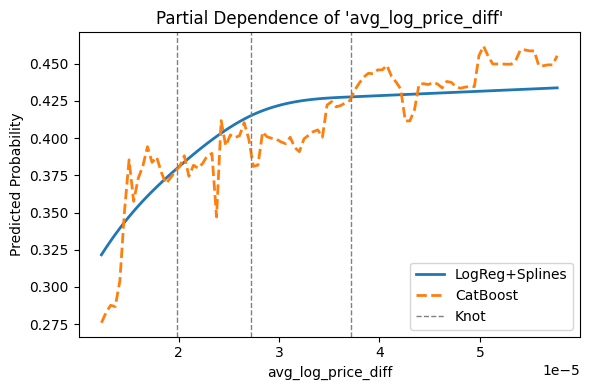

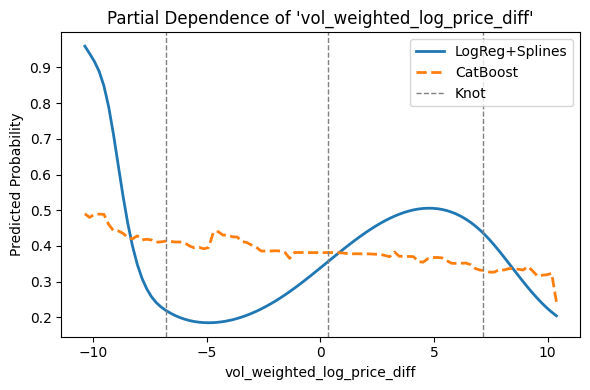

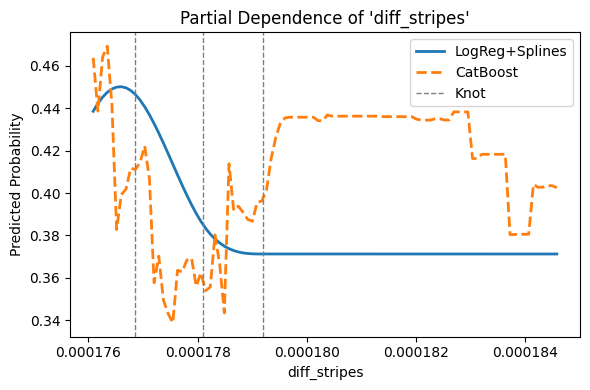

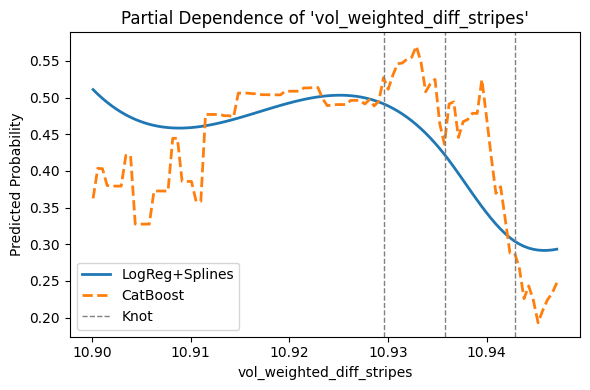

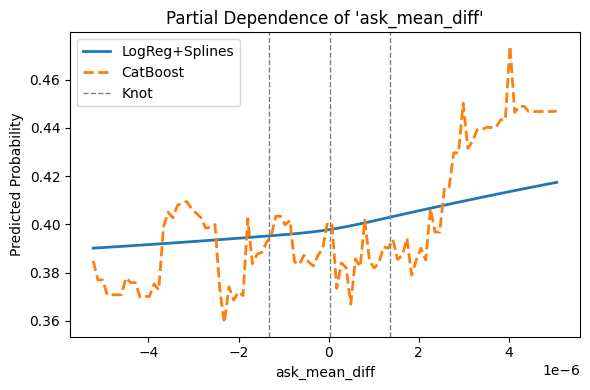

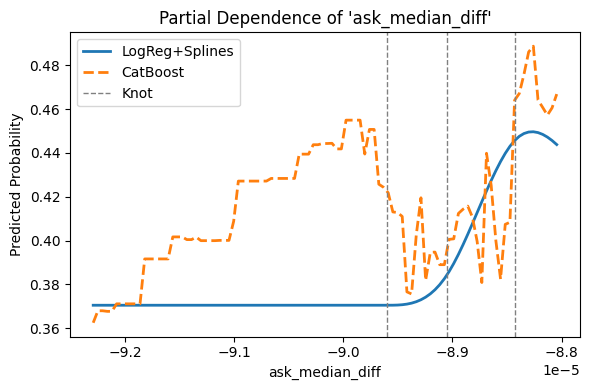

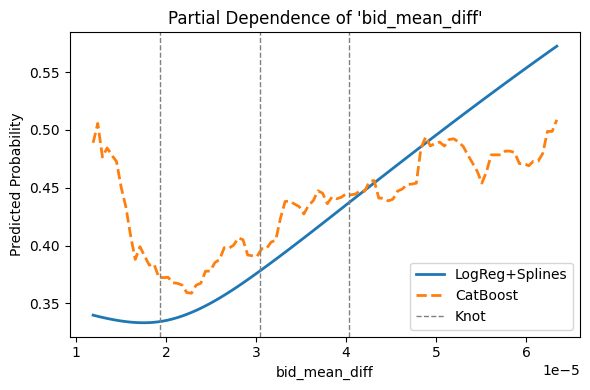

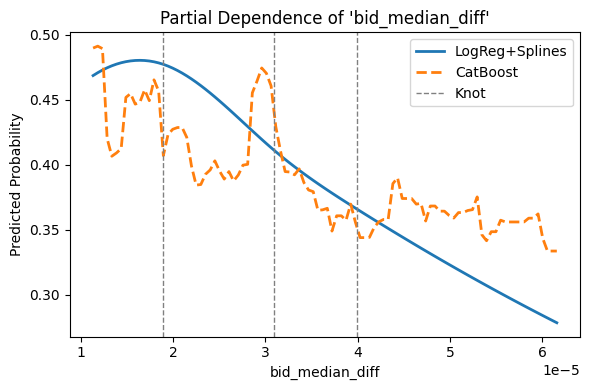

In [73]:
from sklearn.inspection import partial_dependence

for feature_index in range(len(X.columns)):
    feature_name = X_train.columns[feature_index]

    # Spline PDP
    pdp_spline = partial_dependence(
        spline_pipeline, X_train, [feature_index], kind="average", grid_resolution=100
    )
    y_spline = pdp_spline["average"][0]
    x_spline = pdp_spline["grid_values"][0]

    # CatBoost PDP
    pdp_cb = partial_dependence(
        cb, X_train, [feature_index], kind="average", grid_resolution=100
    )
    y_cb = pdp_cb["average"][0]
    x_cb = pdp_cb["grid_values"][0]

    # Plot both
    plt.figure(figsize=(6, 4))
    plt.plot(x_spline, y_spline, label="LogReg+Splines", linewidth=2)
    plt.plot(x_cb, y_cb, label="CatBoost", linestyle="--", linewidth=2)

    # Add knots
    raw_knots = spline_pipeline.named_steps["spline"].bsplines_[feature_index].t
    knots = raw_knots[4:-4]
    for i, k in enumerate(knots):
        plt.axvline(k, color="gray", linestyle="--", linewidth=1,
                    label="Knot" if i == 0 else None)

    plt.title(f"Partial Dependence of '{feature_name}'")
    plt.xlabel(feature_name)
    plt.ylabel("Predicted Probability")
    plt.legend()
    plt.tight_layout()
    plt.show()


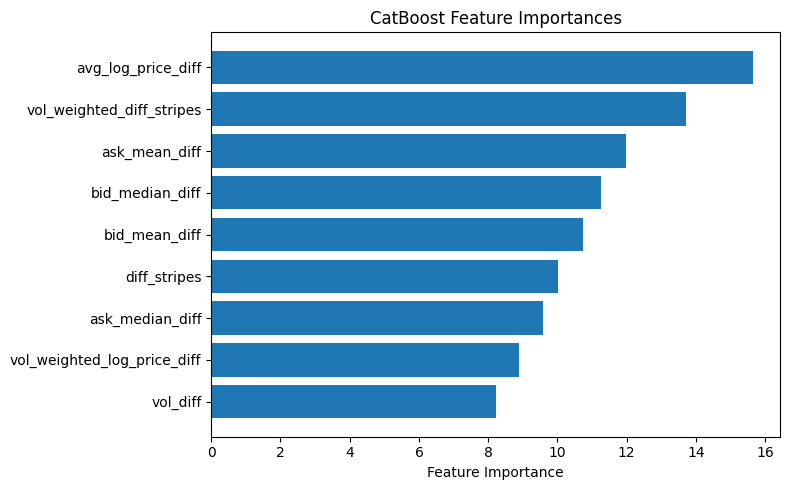

In [74]:
import matplotlib.pyplot as plt
import numpy as np

# Get feature importances and names
importances = cb.get_feature_importance()
feature_names = X_train.columns

# Sort by importance
indices = np.argsort(importances)[::-1]
sorted_importances = importances[indices]
sorted_names = feature_names[indices]

# Plot
plt.figure(figsize=(8, 5))
plt.barh(range(len(sorted_names)), sorted_importances[::-1], align='center')
plt.yticks(range(len(sorted_names)), sorted_names[::-1])
plt.xlabel("Feature Importance")
plt.title("CatBoost Feature Importances")
plt.tight_layout()
plt.show()


In [79]:
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, average_precision_score,
    log_loss
)
import pandas as pd

# Predictions
y_pred_log = spline_pipeline.predict(X_test)
y_pred_cb = cb.predict(X_test)

y_prob_log = spline_pipeline.predict_proba(X_test)[:, 1]
y_prob_cb = cb.predict_proba(X_test)[:, 1]

# Compute metrics
metrics = {
    "Accuracy": [
        accuracy_score(y_test, y_pred_log),
        accuracy_score(y_test, y_pred_cb)
    ],
    "Precision": [
        precision_score(y_test, y_pred_log),
        precision_score(y_test, y_pred_cb)
    ],
    "Recall": [
        recall_score(y_test, y_pred_log),
        recall_score(y_test, y_pred_cb)
    ],
    "F1 Score": [
        f1_score(y_test, y_pred_log),
        f1_score(y_test, y_pred_cb)
    ],
    "ROC AUC": [
        roc_auc_score(y_test, y_prob_log),
        roc_auc_score(y_test, y_prob_cb)
    ],
}

# Create table
metrics_df = pd.DataFrame(metrics, index=["LogReg+Splines", "CatBoost"])


In [80]:
metrics_df

Accuracy  Precision    Recall  F1 Score   ROC AUC
LogReg+Splines  0.646691   0.587406  0.390869  0.469395  0.670397
CatBoost        0.679197   0.633747  0.468209  0.538545  0.731145